# Intro

Hey everyone! This is an introduction to creating your own dataset using [Selenium](https://selenium-python.readthedocs.io/). This notebook's objective is to show you that you don't have to wait until a dataset that looks interesting pops up on Kaggle to start working with data. It is useful and not difficult to begin collecting your own data from the internet using various web scraping tools.

If you are using Selenium in Deepnote instead of locally, make sure to add these lines to the `__init__.ipynb`.

In [ ]:
#%%bash
#sudo apt-get update
#sudo apt-get install chromium-driver -y

**Firstly, why Selenium?**


I recommend Selenium for web scraping because it's a lot more robust than other solutions. Tools like [Beautifulsoup](https://beautiful-soup-4.readthedocs.io/en/latest/) are useful as HTML parsers. However, they cannot automate the whole browser like selenium can. This leads to benefits like scraping with just one library instead of multiple ones, like [bs4](https://pypi.org/project/beautifulsoup4/) and [requests](https://realpython.com/python-requests/). It also means you can handle dynamically loaded content.

In [ ]:
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver import Chrome
from selenium.webdriver.chrome.options import Options
import datefinder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

For Selenium to work in Deepnote, we need to run it in headless mode. Selenium is actually a full browser automation software so running it in headless means we will not visually see the Chrome browser running. If you are running this code locally, you can run it in headful mode, and you will be able to see your browser load up as the code runs. This is typically my favorite part!

In [ ]:

chrome_options = Options()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--headless')
driver = Chrome(options=chrome_options)  # This parameter would be the path to your chromedriver if you are running this locally

Now that we have this running, we can start scraping the web. Let's start with [Wikipedia](https://www.wikipedia.org/) — it has a wealth of information and allows itself to be scraped, so it is a great candidate. If you needed to scrape Wikipedia for a real project and not for learning purposes, know that the [Python Wikipedia](https://towardsdatascience.com/wikipedia-api-for-python-241cfae09f1c) library and the Wikipedia data dumps are better places to get information. With that disclaimer out of the way — let's get started.

In [ ]:
driver.implicitly_wait(3)

The implicitly_wait function means that Selenium will wait up to 3 seconds before telling you that an element does not exist on a page. This is very useful for content that gets loaded in by an AJAX request or another dynamic method.


In [ ]:
driver.get('https://www.halodoc.com/cari-dokter/spesialis/obstetrics-and-gynecologist')

This sends the driver to the webpage we want to scrape. In this case, we are going to start with scraping the Wikipedia page for the [Razzies](https://en.wikipedia.org/wiki/Golden_Raspberry_Awards). The Razzies are sort of the reverse [Oscars Awards](https://en.wikipedia.org/wiki/Academy_Awards).


# XPath

In my experience, one of the easiest ways to access elements on a web page is with [XPath](https://developer.mozilla.org/en-US/docs/Web/XPath). Now for a quick introduction to XPath.
Here is an example XPath expression:

```
"//div[@class = "header_div"]/h3"
```

This expression is saying is to look for a div on the page with a header_div class attribute. Then, find the first heading tag that is contained within that div. All XPath expressions will follow a similar pattern- double slash then tags with search terms attached. This tutorial aims to get started as quickly as possible so we can move on from HPath as this is about as complicated as our expressions will get.

Another useful resource is the [XPath Cheat Sheet](https://devhints.io/xpath). Keep this handy!

Now, let's see if we can grab the title of the Wikipedia article.
Inspect element tells us the title is a header tag with attribute `firstHeading`.

![Picture title](image-20201015-215057.png)

![Picture title](image-20201015-215201.png)

In [ ]:
driver.find_element_by_xpath("//h1[@id='firstHeading']").text

'Golden Raspberry Awards'

Brilliant!

2 things to note:

1. We found the text contained within the element using Selenium's WebElement text attribute
2. Notice the use of both single and double quotes as not to pass an invalid string to the method

Let's grab a couple more information from the Wiki page to have a more complete view of the information we need.

In [ ]:
edited = driver.find_element_by_xpath('//li[@id="footer-info-lastmod"]').text
edited

'This page was last edited on 30 July 2021, at 18:33 (UTC).'

We want to get the data, but this is not an easy format to deal with. Luckily the [datefinder](https://datefinder.readthedocs.io/en/latest/) library is fantastic for extracting dates from unstructured plaintext.


In [ ]:
matches = list(datefinder.find_dates(edited))

if len(matches) > 0:
    # date returned will be a datetime.datetime object. here we are only using the first match.
    date = matches[0]
    print(date)
else:
    print('No dates found')

2021-07-30 18:33:00


This line grabs the time stamp of when the article was last downloaded.

In [ ]:
driver.find_element_by_xpath('//div[@id = "mw-content-text"]').text

'"Golden Raspberry" redirects here. For the fruit, see Raspberry.\nGolden Raspberry Award\nCurrent: 41st Golden Raspberry Awards\nThe Golden Raspberry Award statuette\nAwarded for Worst in film\nCountry United States\nPresented by Golden Raspberry Award Foundation\nFirst awarded March 31, 1981; 40 years ago\nWebsite razzies.com\nThe Golden Raspberry Awards (also known in short terms as Razzies and Razzie Awards) is a parody award show honoring the worst of cinematic under-achievements. Co-founded by UCLA film graduates and film industry veterans John J. B. Wilson and Mo Murphy, the Razzie Awards\' satirical annual ceremony has preceded its polar opposite, the coveted Academy Awards, for four decades. The term raspberry is used in its irreverent sense, as in "blowing a raspberry". The statuette itself is a golf ball-sized raspberry atop a mangled Super 8mm film reel spray-painted gold, with an estimated street value of $4.97. The Golden Raspberry Foundation have claimed that the award "

This line will return all of the content on the page. As long as the text is contained somewhere on the div, the text attribute will return it!


In [ ]:
len(driver.find_elements_by_xpath('//img'))

9

This line tells us how many images are on a given page.


Now that we have explored the page a little, let's try and package these functions to create a dataframe out of a few Wiki pages. The information that we will collect about each webpage is as follows:

1. The title
2. The text body
3. The number of hyperlinks on the page
4. The number of images on the page
5. When it was last edited

In [ ]:
def scrape_wiki(url,driver):
    driver.get(url)
    title = driver.find_element_by_xpath("//div[@class='col-12 col-md-8 col-xl-9 hospital-list--result ng-star-inserted']").text
    data = {"title":title,}
    return pd.Series(data)

In [ ]:
scrape_wiki('https://www.halodoc.com/cari-dokter/spesialis/obstetrics-and-gynecologist',driver)

title    dr. A. Djaenudin, Sp.OG\nKebidanan Kandungan\n...
dtype: object

Let's test if function works on a different article.

In [ ]:
scrape_wiki('https://www.halodoc.com/cari-dokter/spesialis/pediatrician',driver)

title    dr. A. D. Pasaribu, Sp.A\nAnak\nRS Hermina Kem...
dtype: object

Awesome. We have a function that works on both pages! We never even looked at the Oscars Wiki page. Luckily for us, Wikipedia pages are set up in a pretty uniform way.

In [ ]:
driver.get('https://www.halodoc.com/cari-dokter/spesialis/obstetrics-and-gynecologist')

Bring the Webdriver back to the Razzies page.


In [ ]:
wiki_links = [link.get_attribute('href') for link in driver.find_elements_by_xpath('//a[@href]') if "en.wikipedia.org/wiki" in link.get_attribute('href') and "Raspberry" not in link.get_attribute('href')]
wiki_links

[]

This line above looks for every 'a' tag with an href attribute and then gets the link text. Note the use of the find elements method and not find element. Using a convenient list comprehension, we only grab the links to Wiki articles that aren't about the Golden Raspberries. There are a couple of URLs we might not want to scrape as they are meta articles about Wikipedia, but the majority of our work is good.

Now let's try and create a dataframe with all of the links we collected from the Razzies page. By the end of our work, we will have a pandas dataframe with info on the Razzie and all the movies associated with it.

In [ ]:
df = pd.DataFrame()
for link in wiki_links[:15]:
    try:
        df = df.append(scrape_wiki(link,driver),ignore_index=True,verify_integrity=True)
    except NoSuchElementException:
        pass
df


""


We iterate through our links and append the scraped data to our dataframe. This can take some time because we need to access a large number of pages. Feel free to limit the number of links you will scrape if you are feeling impatient.


Let's explore some of the data briefly.


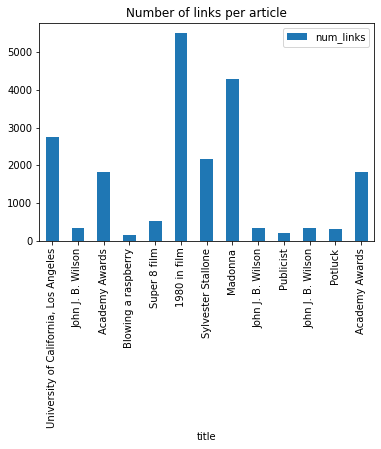

In [ ]:
df.plot(x='title' ,y='num_links', kind='bar')
plt.title('Number of links per article')
plt.show()

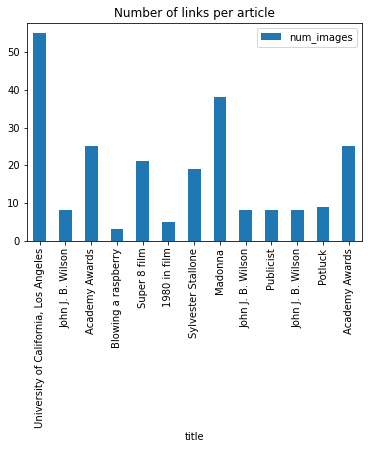

In [ ]:
df.plot(x='title' ,y='num_images', kind='bar')
plt.title('Number of links per article')
plt.show()

Before we wrap up, let's clean up the data a bit. We are going to use the dataframes apply method, which I find incredibly convenient. We will use it to make our description text all lower case. Additionally, we will remove the stopwords. If your goal was to perform NLP tasks on the data, this would be a reasonable step. Stopwords are all of the words in the text necessary for grammar but do not necessarily bring meaning. These words like `at`, `the`, `a`, `to`, etc...


In [ ]:
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def text_clean(text):
    return " ".join([word.lower().strip(" ,'\"") for word in text.split() if word not in stopwords.words("english")])
text_clean("This is a piece of Example Text with Random Punctuation, to Test Our function")

'this piece example text random punctuation test our function'

We can see that the processed text is all lower case, the punctuation has been removed, and words like `with`, `is` and `a` have been removed.


In [ ]:
df.description = df.description.apply(lambda row: text_clean(row))
df.description

0     ucla redirects here. for uses see ucla (disamb...
1     for uses see john wilson. john j. b. wilson wi...
2     oscars the oscar redirect here. for uses see o...
3     bronx cheer redirects here. for law & order ep...
4     this article film format. for abrams/spielberg...
5     list years film … 1970 1971 1972 1973 1974 197...
6     sylvester stallone stallone 2019 born michael ...
7     for uses see madonna (disambiguation). madonna...
8     for uses see john wilson. john j. b. wilson wi...
9     hide this article multiple issues. please help...
10    for uses see john wilson. john j. b. wilson wi...
11    for uses see pot luck (disambiguation). this a...
12    oscars the oscar redirect here. for uses see o...
Name: description, dtype: object

The apply method with apply our `text_clean` function to all of the cells in the description column of the dataframe.

Finally, save our work to CSV, and we are done! Congrats! We are done.

In [ ]:
df.to_csv("wiki.csv")

# Next Steps

So you've gone and collected all of this data from Wikipedia. Now, what do you do with it?
Here are a couple ideas to get you started.

1. Document Similarity
Our code starts grabbing documents from the links present on our first Wikipedia page. Using the descriptions on those Wiki pages, you could find some way to predict if one document is related to another or guess if it is present as a first-degree link. This could be done with [doc2vec](https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e), which would be a great fit to train a model to detect document similarity. More information on document similarity can be found [here](https://towardsdatascience.com/a-complete-beginners-guide-to-document-similarity-algorithms-75c44035df90).

2. Text Generation
With Wikipedia, we can get a lot of text really quickly. Training a model to write a book in the Wikipedia style could be a fascinating problem to tackle. The [transformers](https://huggingface.co/blog/how-to-generate) library is a great place to look at. If you are looking for another Deepnote tutorial about text generation, I have written one [here](https://deepnote.com/publish/e34c35b3-eeb8-4706-962c-57341bd0dafe).

3. Text Classification
There is plenty of data to work with here, so you can think of any given text classification project to start working on. For example, you could create categories of text, say movies, history, and science. Using the tools above, you can collect Wiki articles from different fields and train a text classification model.

These ideas just scratch the surface. You could visualize the data and find out how recently a typical article has been edited. Applying these techniques to any site can make it easy to collect data and work with it.

## Run this notebook in Deepnote

If you want to pick up this work, feel free to *Duplicate* this article next (at the beginning). Or just click below on "Launch in Deepnote"

[<img src="https://deepnote.com/buttons/launch-in-deepnote.svg">](https://deepnote.com/project/09803641-19e4-4db5-9062-a0d0dafdfa29)

If you'll be starting on your own, make sure to install `chromium-driver`.
You can do it from Terminal, directly from a cell using `bash` magic:

```
%%bash
sudo apt-get update
sudo apt-get install chromium-driver -y
```

Or add the following lise into your `Dockerfile` in Environment tab:
```
RUN sudo apt-get update
RUN sudo apt-get install chromium-driver -y
```

# Conclusion

It is straightforward to start collecting data for your own personal projects. There is no better place to find information than online.

If you have any questions about running or writing code like this, please feel free to email me at `josh.zwiebel<at>uwaterloo.ca`.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e1eb8707-e803-48f8-a817-7e4e2cfa40a3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>